In [1]:
# -- use this line at the beginning of your notebook to turn on interactive plots
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget
#%matplotlib 
#%matplotlib ipympl

# Imports
import sys
import matplotlib.pyplot as plt  # plotting library
from matplotlib import colors
import numpy as np  # work with numeric arrays without labeled axes
import xarray as xr  # work with arrays with labeled axes
import xrscipy.signal as dsp  # xarray signal filtering etc.
import scipy as sps
from cdb_extras import xarray_support as cdbxr  # access to COMPASS Database (CDB)
import pickle # to save data
from pathlib import Path # to easily work with different files
from progressbar import ProgressBar
from typing import Optional, Union
from dataclasses import dataclass
from typing import Optional
#plt.rcParams.update({'font.size': 14})


from core.pedestal_fit import PedestalParams, get_thomson_data, fit, pedestal_params_extraction
from core.sawtooth_extraction import ST_detector, ST_time_and_phase, ST_detector_plot
from core.pedestal_ploting import load_pedestal_data, scatter_pedestal_params, get_ELM_ST_phase_and_duration, scatter_pedestal_params_4plots, get_elm_length_and_time

# Only use Thomson data from this normalized psi value and up
psi_n_lim = 0.6
savesaw="/compass/home/odlozilik/repos/ELM-Sawtooth/sawtooth_data"
saveped="/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals"

# <ins> Pedestal fit</ins>

#### Compute multiple fits of pedestals:

In [6]:
#test=pedestal_params_extraction(18254, psi_n_lim,save_path=saveped)

# Create a list here of all the shots you want to extract pedestal parameters for.
shot_list = [18252,18254,18255,18257]
             
for shot_nr in shot_list:
    print(f"\n#### EXTRACTING PEDESTAL PARAMETERS FROM SHOT {shot_nr}\n")
    pedestal_params_extraction(shot_nr, psi_n_lim,save_path=saveped)



#### EXTRACTING PEDESTAL PARAMETERS FROM SHOT 18252



  0% (0 of 55) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


Using stray corrected data
Number of H-mode intervals : 1


 20% (11 of 55) |####                    | Elapsed Time: 0:00:00 ETA:   0:00:02
 21% (12 of 55) |#####                   | Elapsed Time: 0:00:01 ETA:   0:00:04
 23% (13 of 55) |#####                   | Elapsed Time: 0:00:01 ETA:   0:00:06
 25% (14 of 55) |######                  | Elapsed Time: 0:00:02 ETA:   0:00:30
 27% (15 of 55) |######                  | Elapsed Time: 0:00:03 ETA:   0:00:29


Could not fit at 1105ms. Reason: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.


 29% (16 of 55) |######                  | Elapsed Time: 0:00:08 ETA:   0:03:21


Huge error on b_height at 1114ms. err: 4.4e+22, val:4.1e+04. Dropping it.


 30% (17 of 55) |#######                 | Elapsed Time: 0:00:10 ETA:   0:02:06
 32% (18 of 55) |#######                 | Elapsed Time: 0:00:10 ETA:   0:01:28
 34% (19 of 55) |########                | Elapsed Time: 0:00:11 ETA:   0:00:29
 36% (20 of 55) |########                | Elapsed Time: 0:00:11 ETA:   0:00:27


Huge error on b_height at 1147ms. err: 6.8e+22, val:5.9e+04. Dropping it.


 38% (21 of 55) |#########               | Elapsed Time: 0:00:13 ETA:   0:00:40
 40% (22 of 55) |#########               | Elapsed Time: 0:00:14 ETA:   0:00:38
 41% (23 of 55) |##########              | Elapsed Time: 0:00:14 ETA:   0:00:33
 43% (24 of 55) |##########              | Elapsed Time: 0:00:16 ETA:   0:00:35


Huge error on b_height at 1180ms. err: 3.4e+02, val:3.4e+02. Dropping it.


 45% (25 of 55) |##########              | Elapsed Time: 0:00:17 ETA:   0:00:40
 47% (26 of 55) |###########             | Elapsed Time: 0:00:18 ETA:   0:00:31


Could not fit 1 out of 55 measurements.

#### EXTRACTING PEDESTAL PARAMETERS FROM SHOT 18254



  0% (0 of 55) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


Using stray corrected data
Number of H-mode intervals : 5


 20% (11 of 55) |####                    | Elapsed Time: 0:00:00 ETA:   0:00:02
 21% (12 of 55) |#####                   | Elapsed Time: 0:00:01 ETA:   0:00:03
 23% (13 of 55) |#####                   | Elapsed Time: 0:00:01 ETA:   0:00:04
 25% (14 of 55) |######                  | Elapsed Time: 0:00:02 ETA:   0:00:06
 27% (15 of 55) |######                  | Elapsed Time: 0:00:02 ETA:   0:00:21
 29% (16 of 55) |######                  | Elapsed Time: 0:00:03 ETA:   0:00:21


Huge error on b_height at 1114ms. err: 1.8e+22, val:5.0e+04. Dropping it.


 30% (17 of 55) |#######                 | Elapsed Time: 0:00:05 ETA:   0:00:45
 32% (18 of 55) |#######                 | Elapsed Time: 0:00:05 ETA:   0:00:44
 34% (19 of 55) |########                | Elapsed Time: 0:00:06 ETA:   0:00:34
 36% (20 of 55) |########                | Elapsed Time: 0:00:06 ETA:   0:00:29
 38% (21 of 55) |#########               | Elapsed Time: 0:00:07 ETA:   0:00:21
 40% (22 of 55) |#########               | Elapsed Time: 0:00:08 ETA:   0:00:22
 41% (23 of 55) |##########              | Elapsed Time: 0:00:08 ETA:   0:00:22
 43% (24 of 55) |##########              | Elapsed Time: 0:00:09 ETA:   0:00:23
 45% (25 of 55) |##########              | Elapsed Time: 0:00:11 ETA:   0:00:34
 47% (26 of 55) |###########             | Elapsed Time: 0:00:11 ETA:   0:00:28
 61% (34 of 55) |##############          | Elapsed Time: 0:00:12 ETA:   0:00:05
 63% (35 of 55) |###############         | Elapsed Time: 0:00:12 ETA:   0:00:05
 65% (36 of 55) |###############        

Could not fit 0 out of 55 measurements.

#### EXTRACTING PEDESTAL PARAMETERS FROM SHOT 18255



  0% (0 of 54) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


Using stray corrected data
Number of H-mode intervals : 5


 20% (11 of 54) |####                    | Elapsed Time: 0:00:00 ETA:   0:00:01
 22% (12 of 54) |#####                   | Elapsed Time: 0:00:01 ETA:   0:00:03
 24% (13 of 54) |#####                   | Elapsed Time: 0:00:01 ETA:   0:00:05
 25% (14 of 54) |######                  | Elapsed Time: 0:00:02 ETA:   0:00:06
 27% (15 of 54) |######                  | Elapsed Time: 0:00:02 ETA:   0:00:24
 29% (16 of 54) |#######                 | Elapsed Time: 0:00:03 ETA:   0:00:23
 31% (17 of 54) |#######                 | Elapsed Time: 0:00:04 ETA:   0:00:32
 33% (18 of 54) |########                | Elapsed Time: 0:00:06 ETA:   0:00:42
 35% (19 of 54) |########                | Elapsed Time: 0:00:06 ETA:   0:00:35


Huge error on b_height at 1139ms. err: 2.5e+19, val:4.6e+18. Dropping it.
Huge error on b_height at 1139ms. err: 7.8e+01, val:3.5e+01. Dropping it.


/sw/python/3.9-anaconda-2023.07/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/sw/python/3.9-anaconda-2023.07/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/sw/python/3.9-anaconda-2023.07/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
 37% (20 of 54) |########                | Elapsed Time: 0:00:09 ETA:   0:01:20


Huge error on b_height at 1139ms. err: 2.9e+06, val:4.5e+00. Dropping it.


 38% (21 of 54) |#########               | Elapsed Time: 0:00:09 ETA:   0:00:49
 40% (22 of 54) |#########               | Elapsed Time: 0:00:10 ETA:   0:00:42
 42% (23 of 54) |##########              | Elapsed Time: 0:00:11 ETA:   0:00:24
 44% (24 of 54) |##########              | Elapsed Time: 0:00:11 ETA:   0:00:22


Could not fit at 1180ms. Reason: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.


 46% (25 of 54) |###########             | Elapsed Time: 0:00:16 ETA:   0:02:19
 48% (26 of 54) |###########             | Elapsed Time: 0:00:17 ETA:   0:01:14
 59% (32 of 54) |##############          | Elapsed Time: 0:00:17 ETA:   0:00:16
 61% (33 of 54) |##############          | Elapsed Time: 0:00:18 ETA:   0:00:15
 62% (34 of 54) |###############         | Elapsed Time: 0:00:19 ETA:   0:00:05
 64% (35 of 54) |###############         | Elapsed Time: 0:00:19 ETA:   0:00:04
 66% (36 of 54) |################        | Elapsed Time: 0:00:21 ETA:   0:00:15
 68% (37 of 54) |################        | Elapsed Time: 0:00:21 ETA:   0:00:17
 70% (38 of 54) |################        | Elapsed Time: 0:00:22 ETA:   0:00:15


Could not fit 1 out of 54 measurements.

#### EXTRACTING PEDESTAL PARAMETERS FROM SHOT 18257



  0% (0 of 56) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


Using stray corrected data
Number of H-mode intervals : 2


 21% (12 of 56) |#####                   | Elapsed Time: 0:00:00 ETA:   0:00:02
 23% (13 of 56) |#####                   | Elapsed Time: 0:00:01 ETA:   0:00:04
 25% (14 of 56) |######                  | Elapsed Time: 0:00:01 ETA:   0:00:05


Huge error on b_height at 1097ms. err: 1.1e+22, val:4.9e+04. Dropping it.


 26% (15 of 56) |######                  | Elapsed Time: 0:00:03 ETA:   0:01:27
 28% (16 of 56) |######                  | Elapsed Time: 0:00:04 ETA:   0:00:58
 30% (17 of 56) |#######                 | Elapsed Time: 0:00:06 ETA:   0:00:42


Huge error on b_height at 1122ms. err: 2.4e+10, val:4.5e+04. Dropping it.


 32% (18 of 56) |#######                 | Elapsed Time: 0:00:07 ETA:   0:00:53
/sw/python/3.9-anaconda-2023.07/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/sw/python/3.9-anaconda-2023.07/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/sw/python/3.9-anaconda-2023.07/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
 33% (19 of 56) |########                | Elapsed Time: 0:00:09 ETA:   0:00:53


Huge error on b_height at 1130ms. err: 1.8e+02, val:1.2e+02. Dropping it.


 35% (20 of 56) |########                | Elapsed Time: 0:00:09 ETA:   0:00:38
 37% (21 of 56) |#########               | Elapsed Time: 0:00:10 ETA:   0:00:33


Huge error on b_height at 1155ms. err: 1.4e+22, val:6.1e+04. Dropping it.


 39% (22 of 56) |#########               | Elapsed Time: 0:00:12 ETA:   0:00:40
 41% (23 of 56) |#########               | Elapsed Time: 0:00:12 ETA:   0:00:36
 42% (24 of 56) |##########              | Elapsed Time: 0:00:13 ETA:   0:00:29
 44% (25 of 56) |##########              | Elapsed Time: 0:00:13 ETA:   0:00:25
 46% (26 of 56) |###########             | Elapsed Time: 0:00:14 ETA:   0:00:17
 48% (27 of 56) |###########             | Elapsed Time: 0:00:15 ETA:   0:00:18
 60% (34 of 56) |##############          | Elapsed Time: 0:00:15 ETA:   0:00:04
 62% (35 of 56) |###############         | Elapsed Time: 0:00:16 ETA:   0:00:05
 64% (36 of 56) |###############         | Elapsed Time: 0:00:16 ETA:   0:00:04
 66% (37 of 56) |###############         | Elapsed Time: 0:00:17 ETA:   0:00:04


Could not fit 0 out of 56 measurements.


#### Test fit algorithm with plot:

Using stray corrected data


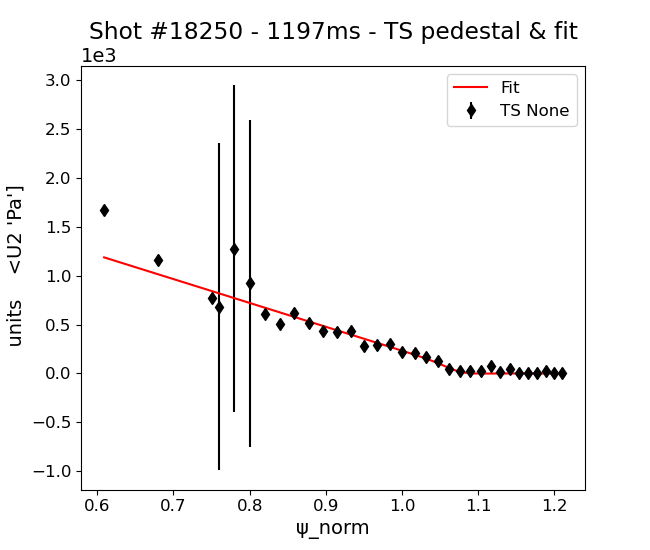

In [2]:
# Just for testing the fitting algorithm
if True: # Set to True and run this block of code to test the fitting algorithm
    shot_nr = 18250
    time = 1200
    ne, ne_err, Te, Te_err, pe, pe_err, psi_n, psi_n_fit_coords, t_H_mode_start, t_H_mode_end = get_thomson_data(shot_nr, psi_n_lim)
    d = pe.sel(time=time, method='nearest')
    e = pe_err.sel(time=time, method='nearest')
    psi_n_one = psi_n.sel(time=time, method='nearest')

    fit(data=d, error=e, psi_n=psi_n_one,psi_n_lim=psi_n_lim, shot_nr=shot_nr, plot=True)

# <ins>  Plots - pedestal parameters after ST and ELMs

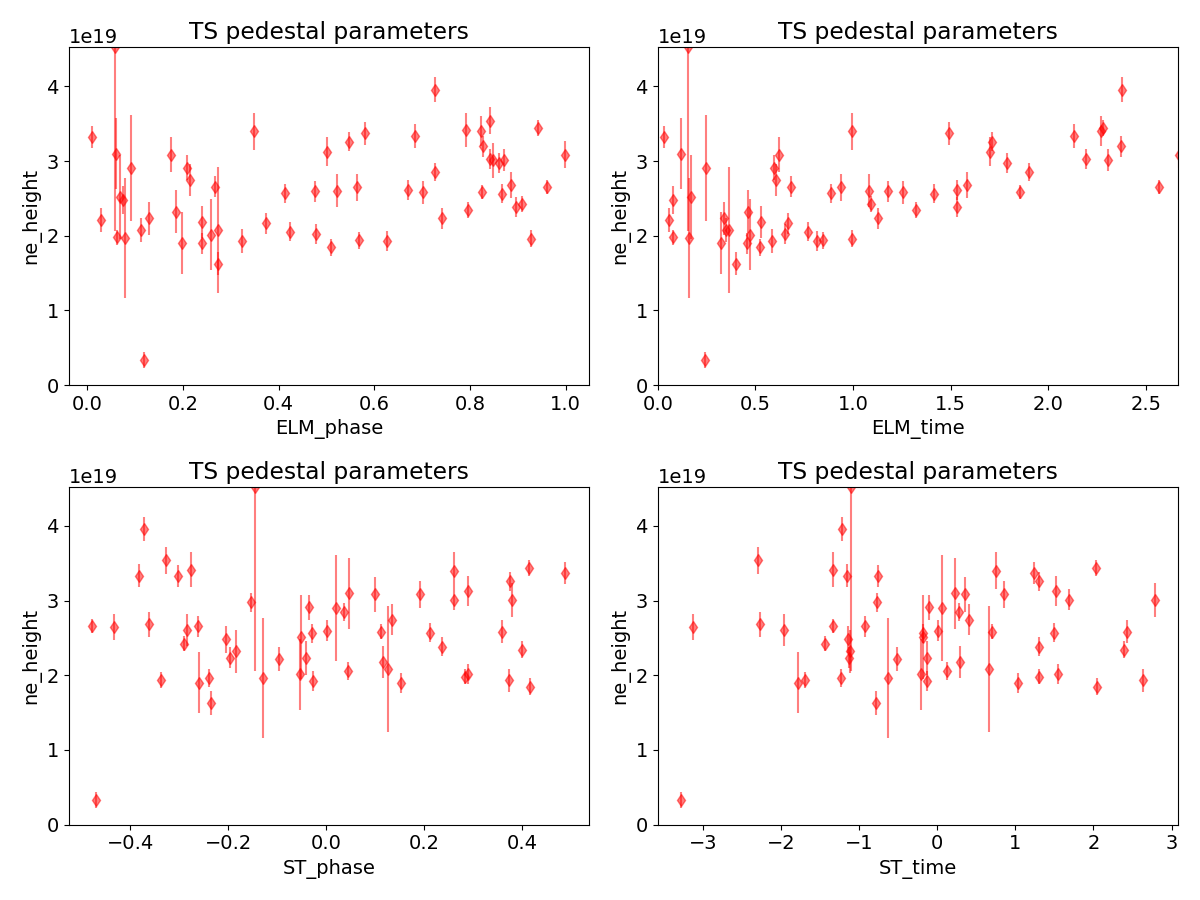

In [7]:
# Create a single figure with multiple subplots
variable = 'ne' # One of 'pe', 'Te', 'ne'
parameter = 'height' # One of 'grad', 'height', 'width'
fig, axes = plt.subplots(2, 2, figsize=(12, 9))  # 2 rows, 2 columns

# Plot on each subplot
scatter_pedestal_params_4plots(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals', x='ELM_phase', s=variable, p=parameter, ax=axes[0, 0])
scatter_pedestal_params_4plots(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals', x='ELM_time', s=variable, p=parameter, ax=axes[0, 1])
scatter_pedestal_params_4plots(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals', x='ST_phase', s=variable, p=parameter, ax=axes[1, 0])
scatter_pedestal_params_4plots(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals', x='ST_time', s=variable, p=parameter, ax=axes[1, 1])

plt.tight_layout()  # Adjust layout for better appearance
plt.show()

Text(0, 0.5, 'Pedestal pressure height [Pa]')

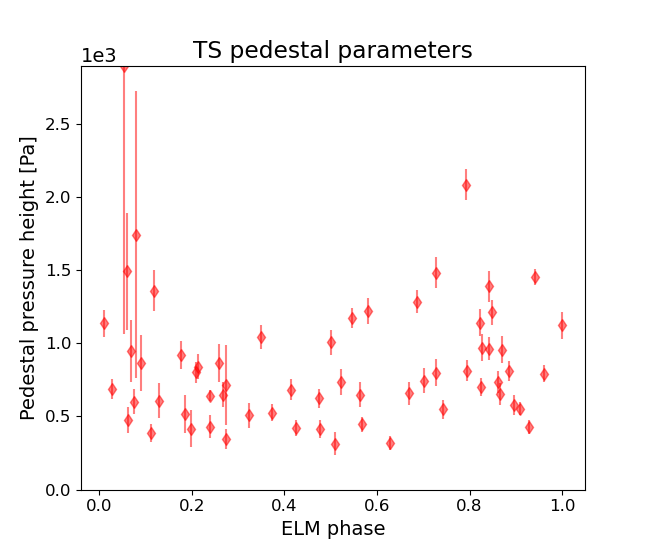

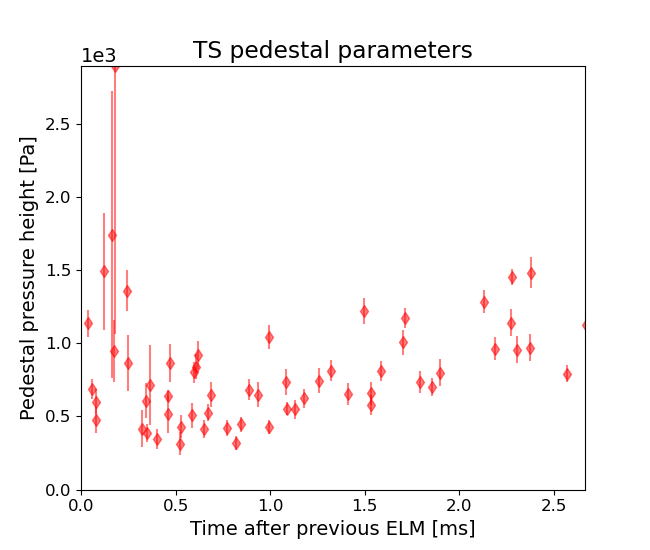

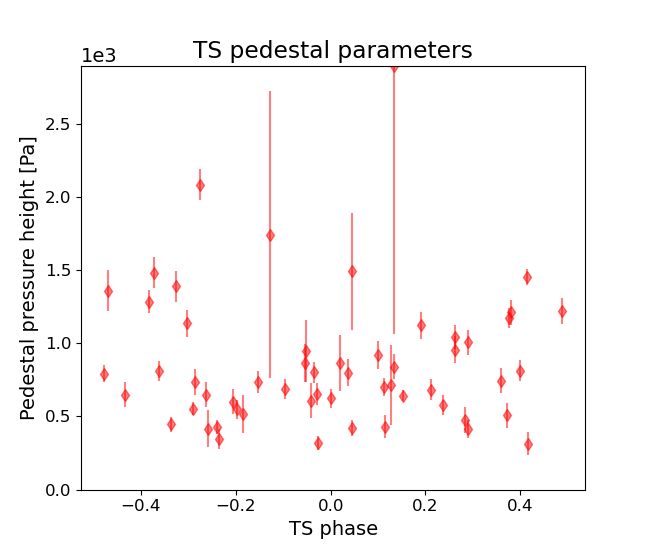

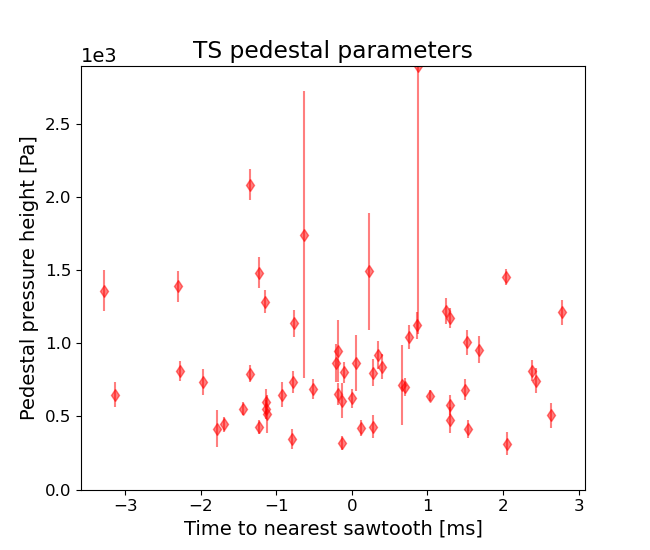

In [8]:
#Plots each figure seperately

variable = 'pe' # One of 'pe', 'Te', 'ne'
parameter = 'height' # One of 'grad', 'height', 'width'

# Generate plots
scatter_pedestal_params(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals', x='ELM_phase', s=variable, p=parameter)
plt.xlabel('ELM phase')
plt.ylabel('Pedestal pressure height [Pa]')


scatter_pedestal_params(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals',x='ELM_time', s=variable, p=parameter)
plt.xlabel('Time after previous ELM [ms]')
plt.ylabel('Pedestal pressure height [Pa]')


scatter_pedestal_params(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals',x='ST_phase', s=variable, p=parameter)
plt.xlabel('TS phase')
plt.ylabel('Pedestal pressure height [Pa]')

scatter_pedestal_params(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals',x='ST_time', s=variable, p=parameter)
plt.xlabel('Time to nearest sawtooth [ms]')
plt.ylabel('Pedestal pressure height [Pa]')

In [4]:
pedestal_data_list=load_pedestal_data(load_path='/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals')


In [7]:
pedestal_data_list

[SawtoothCrashes(shot_number=18266, times=array([1073.971 , 1075.787 , 1077.4845, 1081.5735, 1085.729 , 1090.41  ,
        1095.936 , 1102.1925, 1109.0985, 1116.08  , 1122.963 , 1128.9975,
        1134.2275, 1139.6325, 1144.4475, 1149.3335, 1153.9485, 1159.6905,
        1165.867 ]), amplitudes=array([3.09930757e-08, 1.17354129e-08, 4.77082011e-08, 7.69511524e-08,
        9.62278867e-08, 1.42934353e-07, 1.79070345e-07, 2.22347681e-07,
        2.18802221e-07, 2.28696554e-07, 2.00923091e-07, 1.34234552e-07,
        1.03985991e-07, 9.53921787e-08, 7.82321821e-08, 8.55380874e-08,
        7.41253844e-08, 7.38230295e-08, 7.07409860e-08])),
 PedestalParams(shot_number=18275, ne_height=array([2.02514385e+19, 3.03765612e+19, 2.12953133e+19, 2.73431059e+19,
        2.11023701e+19, 1.64432655e+19, 2.07380599e+19, 1.72813308e+19,
        1.98922285e+19, 1.72786809e+19, 2.71610241e+19, 1.94972934e+19,
        2.02552130e+19, 1.86011015e+19, 2.23520600e+19]), ne_height_err=array([1.02991385e+18, 1.34

# <ins>  ST detection

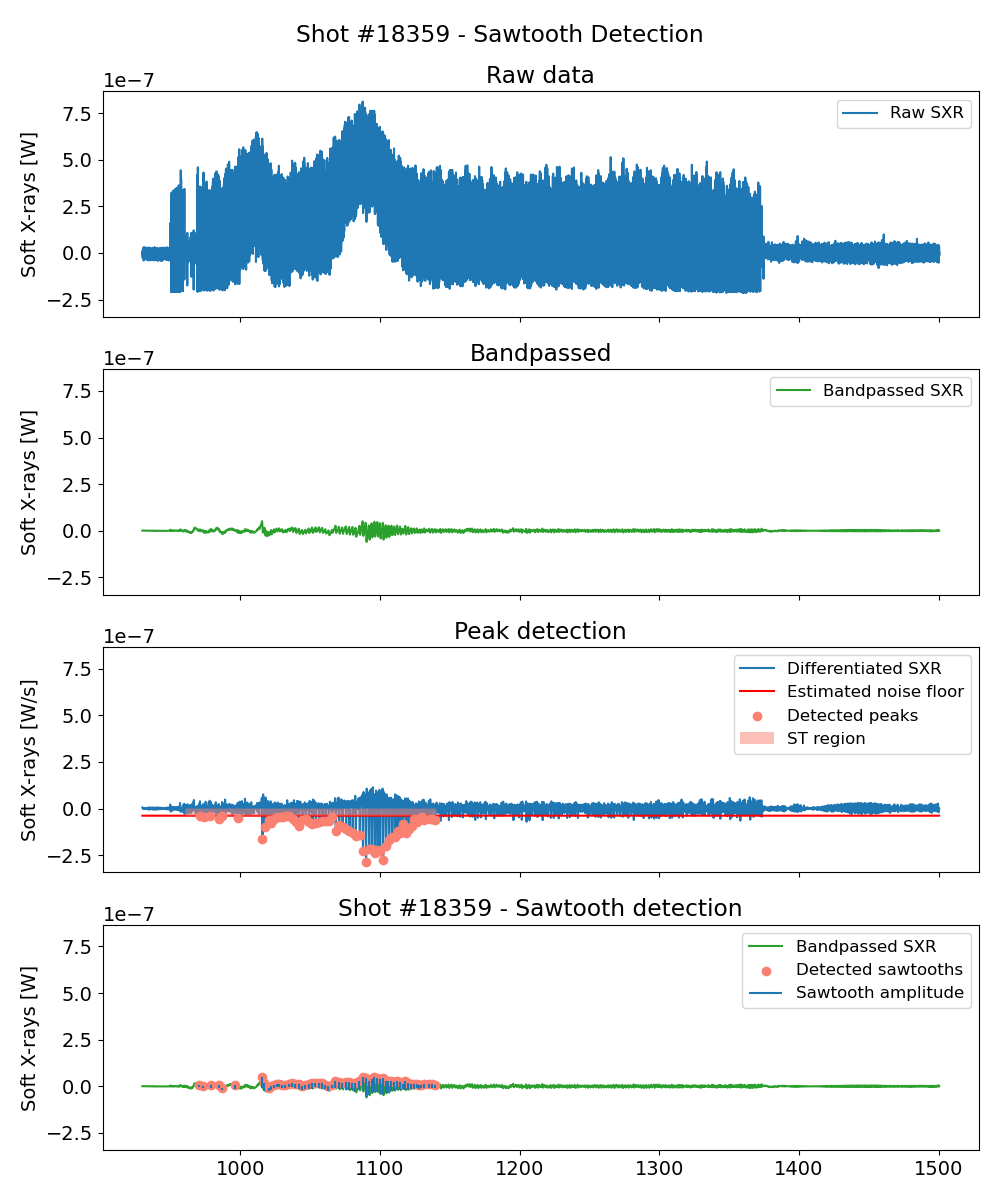

In [3]:
ST_detector_plot(shot_nr=18359, is_core=True,share_y=True)

In [5]:
ST_detector(18359, with_plots=False,save_path=savesaw, is_core=True)

SawtoothCrashes(shot_number=18359, times=array([ 970.932 ,  973.8805,  978.473 ,  985.098 ,  987.3335,  998.644 ,
       1015.9595, 1017.734 , 1020.714 , 1022.375 , 1024.472 , 1026.385 ,
       1028.232 , 1030.332 , 1032.692 , 1035.0845, 1037.5135, 1039.8495,
       1042.1675, 1044.5515, 1046.9165, 1049.2735, 1051.7735, 1054.1615,
       1056.673 , 1059.021 , 1061.147 , 1063.5205, 1065.968 , 1068.441 ,
       1070.9135, 1073.3185, 1075.8975, 1078.259 , 1080.575 , 1082.775 ,
       1085.629 , 1087.894 , 1090.136 , 1092.34  , 1094.3125, 1096.3585,
       1098.37  , 1100.203 , 1102.337 , 1104.418 , 1106.4685, 1108.535 ,
       1110.5905, 1112.663 , 1114.704 , 1116.518 , 1118.5265, 1120.5515,
       1122.6695, 1124.615 , 1126.622 , 1128.458 , 1130.164 , 1131.9495,
       1135.553 , 1137.546 , 1139.6885]), amplitudes=array([9.05105823e-09, 1.26002723e-08, 1.89905429e-08, 1.58779681e-08,
       9.79023075e-09, 1.74307113e-08, 6.17856494e-08, 4.15267049e-08,
       1.70259121e-08, 2.28796808e